# **Digit Recognizer**

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score

## Loading train/test data

In [2]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
train_data.head()
# first element is the lable, the 784 rest are the input image pixsls

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print(f'data shape is {train_data.shape}')

data shape is (42000, 785)


In [4]:
## Separating labeled values from input values, convert to numpy array, and cast its type
X = (train_data.iloc[:,1:].values).astype('float32')
Y = (train_data.iloc[:,0].values).astype('int32')
X_test = (test_data.values).astype('float32')

## Divid dataset to train and validation

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.2)

In [6]:
print(f'X_train shape is {X_train.shape}')
print(f'X_val shape is {X_val.shape}')

X_train shape is (33600, 784)
X_val shape is (8400, 784)


## Data visualization

In [7]:
np.sqrt(784)

28.0

In [8]:
# To visualize the images
def show_data(ax,X,Y,index):
    ax.imshow(X[index,:].reshape(image_size, image_size), cmap= 'gray')
    ax.set_title('y='+str(Y[index]))

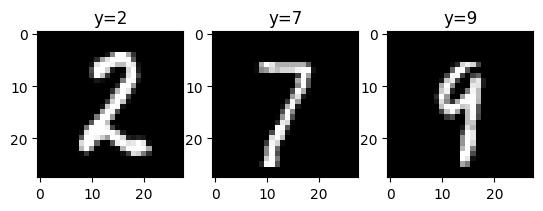

In [9]:
image_size = 28
X_train = X_train.reshape(X_train.shape[0],image_size,image_size)

# plot a couple of images
fig, ax = plt.subplots(1,3)
for i in range(3):
    show_data(ax[i],X_train, Y_train, i+10)

**Expand data shape to add 1 dimension for gray color**

In [10]:
X_train = X_train.reshape(X_train.shape[0],image_size,image_size,1)
X_val = X_val.reshape(X_val.shape[0],image_size,image_size,1)
X_test = X_test.reshape(X_test.shape[0],image_size,image_size,1)
print(f'Shape of train data is {X_train.shape}')
print(f'Shape of validatio data is {X_val.shape}')
print(f'Shape of test data is {X_test.shape}')

Shape of train data is (33600, 28, 28, 1)
Shape of validatio data is (8400, 28, 28, 1)
Shape of test data is (28000, 28, 28, 1)


## Creating Dataset and Data loaders

In [11]:
class dataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
        
# reshape data
X_train = X_train.reshape(-1, 1, image_size, image_size).astype('float32')
X_val = X_val.reshape(-1, 1, image_size, image_size).astype('float32')

# dataset and dataloader
train_data = dataset(X_train, Y_train)
train_loader = DataLoader(train_data, 
                         batch_size = 100, 
                         shuffle = True, 
                         drop_last = True)

val_data = dataset(X_val, Y_val)
val_loader = DataLoader(val_data, 
                         batch_size = 100, 
                         shuffle = False, 
                         drop_last = False)


## Convolutional Neural Network

In [12]:
# fix random seed for reproducability 
np.random.seed(43)

class CNN(nn.Module):
    def __init__(self,out_1, out_2 ):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc = nn.Linear(out_2*7*7, 10)
    def forward(self, x):
        x = self.cnn1(x)
        x= torch.relu(x)
        x= self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

model = CNN(16,32)
model.eval()
print(model)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [13]:
def training_cnn(n_epochs, train_loader, val_loader, model, optimizer, criterion):
    cost_list = []
    accuracy_list = []
    model.train()
    for epoch in range(n_epochs):
        #-- Tuning
        cost = 0 
        for x,y in train_loader: 
            # reset optimizer
            optimizer.zero_grad()
            predict = model(x)
            # calculate loss
            loss = criterion(predict, y)
            # calculate gradients
            loss.backward()
            # update parameters
            optimizer.step()
            cost += loss
        cost_list.append(cost.item())
        
        #-- Validation
        model.eval()
        correct = 0 
        N_test = 0
        for x_val,y_val in val_loader:
            z_val = model(x_val)
            _, yhat = torch.max(z_val.data,1)
            correct += (yhat==y_val).sum().item()
            N_test += y_val.size(0)
        curr_accuracy = 100*correct/N_test
        accuracy_list.append(curr_accuracy)
        print(f"For epoch number {epoch}, the training loss is {cost}, and the validation accuracy is {curr_accuracy}%")
    return cost_list , accuracy_list


# Tuning CNN Model
learning_rate = 0.001
n_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate , weight_decay = 0.1)

cost_list , accuracy_list = training_cnn(n_epochs = n_epochs, 
                                        train_loader = train_loader, 
                                        val_loader = val_loader, 
                                        model = model, 
                                        optimizer = optimizer,
                                        criterion = criterion)
            

For epoch number 0, the training loss is 286.4225158691406, and the validation accuracy is 94.27380952380952%
For epoch number 1, the training loss is 53.0833625793457, and the validation accuracy is 95.94047619047619%
For epoch number 2, the training loss is 39.256690979003906, and the validation accuracy is 96.53571428571429%
For epoch number 3, the training loss is 32.744163513183594, and the validation accuracy is 96.88095238095238%
For epoch number 4, the training loss is 28.609806060791016, and the validation accuracy is 97.38095238095238%
For epoch number 5, the training loss is 25.50507926940918, and the validation accuracy is 97.30952380952381%
For epoch number 6, the training loss is 23.691904067993164, and the validation accuracy is 97.48809523809524%
For epoch number 7, the training loss is 22.052963256835938, and the validation accuracy is 97.86904761904762%
For epoch number 8, the training loss is 20.879175186157227, and the validation accuracy is 97.96428571428571%
For e

## Plot loss and accuracy results

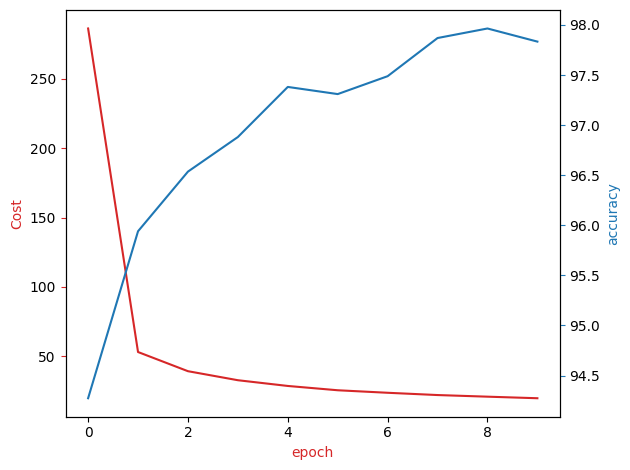

In [14]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot(accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

## Evaluate some miss-classified examples

yhat:  tensor([9])
yhat:  tensor([8])
yhat:  tensor([8])
yhat:  tensor([9])
yhat:  tensor([9])


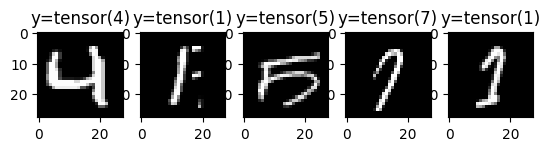

In [15]:
count = 5
counter = 0
fig,ax = plt.subplots(1,count)
# iterate over a dataLoader with batch-size of 1
for x, y in DataLoader(val_data, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data(ax[counter],x, y, 0)
        print("yhat: ",yhat)
        counter += 1
    if counter >= 5:
        break

## Generating estimation for test data

In [16]:
# prepare x_test
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, image_size, image_size)

# Inference (no gradients needed)
with torch.no_grad():
    z_prediction = model(X_test_tensor)
    test_prediction = torch.argmax(z_prediction, dim=1).numpy()

# Save as CSV
pd.DataFrame(test_prediction).to_csv('sample_submission.csv', index=True, header=False)